In [339]:
df <- read.csv('southern_osc.csv')

# just looking at the top five rows of the data...
df[1:5,]

Date,T_i
Jan-51,1.5
Feb-51,0.9
Mar-51,-0.1
Apr-51,-0.3
May-51,-0.7


In [340]:
apply_year <- function(year_2) {
    
    if (year_2 <= 99 && year_2 >= 50) {
        year_4 <- as.integer(paste('19', as.character(year_2), sep=''))
    }
    
    else if (year_2 < 10) {
        year_4 <- as.integer(paste('200', as.character(year_2), sep=''))
    }
    
    else {
        year_4 <- as.integer(paste('20', as.character(year_2), sep=''))
    }
    
    return (year_4)
}

## Faffing with dates...

In [341]:
# string manipulation
df$Month <- substr(df$Date, 1, 3)
df$Year2 <- as.integer(substr(df$Date, 5, 6))

# getting the year 4's from the year 2's
df$Year4 <- apply(df['Year2'], 1, apply_year)

# turning that into a proper date (first of the month)
df$Date <- as.Date(paste('01', df$Month, df$Year4, sep='-'), format = '%d-%b-%Y')

## Quick double check to ensure I've got the right min...

In [342]:
min(df$Year4)

[1] 1951

## Getting rid of the non-needed columns

In [343]:
df <- df[,c('Date','T_i')]

## Plotting

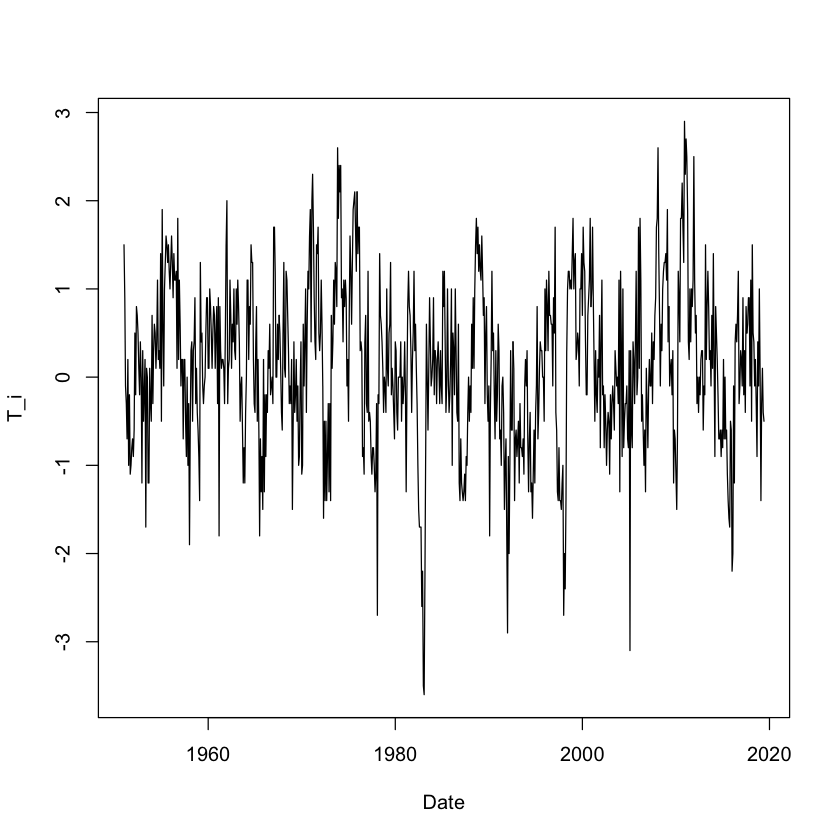

In [344]:
plot(df$Date, df$T_i, type='l', xlab = 'Date', ylab = 'T_i')

## Now on to the actual (partial) autocorrelation bit...

In [345]:
df[1:5,]

Date,T_i
1951-01-01,1.5
1951-02-01,0.9
1951-03-01,-0.1
1951-04-01,-0.3
1951-05-01,-0.7


### Key assumption in an **AR(1)** model:

> $Y_{t} = \phi Y_{t-1} + \epsilon_{t}$,

is that the variance of $Y_{t-1}$ expresses the variance by **all** values older than $Y_{t-1}$.

*If this is not true*, then the **AR(1)** model does not accurately reflect the process $\{Y_{t}\}$, and you will need to explore an **AR(2)** model which includes $Y_{t-2}$, since you  need the extra  term to provide additional, *unexplained variance* in $Y_{t}$.

### **AR(2)** model:

> $Y_{t} = \phi_{1} Y_{t-1} + \phi_{2} Y_{t-2} + \epsilon_{t}$.

The idea here is that the $Y_{t-2}$ will now capture all of the variance from earlier values of $Y_{t-i}$ ($i \geq 2$) not captured by $Y_{t-1}$.


### Remember, a condition of a stationary model is that the variance of $Y_{t}$ and $Y_{t-1}$ should be the same, because these are the **Covariances** of:

* Cov($Y_{t-1}$, $Y_{t-1}$)
* Cov($Y_{t}$, $Y_{t}$)

And both of these just depend on the lag between them, **not $t$**!!

So $Var(Y_{t}) = Var(Y_{t-1}) = \gamma_{0}$

## Why does any of this matter?

* We want to find out what *p* is in our AR(p) model.

* If all of the variance of previous $Y_{t}$ values is explained by $Y_{t-1}$, then AR(1) is great, otherwise you need to look at  AR(2), AR(3), AR($x$), ...

* So we want to know how important the variance from a previous $Y_{t-i}$ value is to predict $Y_{t}$.

* The correlation between two random variables tells us how much and in what  direction the variance in one r.v. impacts the other. Covariance is the joint variability of two random variables. Correlation is just a  normalised measure of covariance, scaled for the variance of each r.v.

* What we actually figure out the correlation between:

> 1. The amount of variance in $T_{i}$ that is **not explained** by $T_{i-1}$.

> 1. Is basically what's missing from what's already in the AR(1) model

> 2. The amount of variance in $T_{i-2}$ that is **not explained** by $T_{i-1}$

> 2. Is basically  what's additionally  provided by $T_{i-2}$ that **isn't already provided by the intervening variables**.

1. could by high, but 2. could be low, because essentially a significant chunk of variance in $Y_{t}$ is coming from an external feature - not itself from a previous point in time.

## Key thing to remember:

> There's this indirect... partial... method of finding the correlation between $T_{i}$ and $T_{i-2}$, because if you did a direct Cov($T_{i}$, $T_{i-2}$) then you'd get covariance that included the effect of the intervening $T_{i-1}$.

> So it's (1): Find out the amount of $T_{i}$ variance not covered by $T_{i-1}$

> (1) are the residuals of the regession of $T_{i}$ on $T_{i-1}$

> Then (2): Find out the variance of $T_{i-2}$ that's not covered / explained by $T_{i-1}$.

> (2) are the residuals of the regression of $T_{i-2}$ on $T_{i-1}$

> **The Covariance between (1) and (2) is the partial covariance between $T_{i-2}$ and. $T_{i}$**

## Formalising this a bit more:

The partial autocorrelation (PAC) of $T_{i}$ with a $\tau$ lagged version of itself - i.e. $T_{t-\tau}$ - is a correlation between the following variables:

1. The amount of variance in $T_{i}$ not explained by $T_{i-1}$, $T_{i-2}$, ..., $T_{i-\tau+1}$

> so the amount of variance in $T_{i}$ not explained by all of the interveening $T_{i}$'s, up to $T_{i-\tau}$

2. The amount of variance in $T_{i-\tau}$ not explained by all of the intervening $T_{i}$'s inbetween *but not including* $T_{i-\tau}$ and $T_{i}$.

## How to implement on  real data:

* Will guage the variance between one lag and another by creating a linear regression model between $y = T_{i}$ and $x = T_{i-1}$, and then use that model to predict $\hat{y}$, and the variance in the residuals gives you the variance contributed by $T_{i-1}$ towards $T_{i}$

In [346]:
# applying shifts by hand
df['T_i_1'] <- c(NA, df['T_i'][1:dim(df['T_i'])[1]-1,])
df['T_i_2'] <- c(NA, df['T_i_1'][1:dim(df['T_i_1'])[1]-1,])

# removing the NA's
df <- df[3:dim(df)[1],]

In [347]:
df[1:10,]

,Date,T_i,T_i_1,T_i_2
3,1951-03-01,-0.1,0.9,1.5
4,1951-04-01,-0.3,-0.1,0.9
5,1951-05-01,-0.7,-0.3,-0.1
6,1951-06-01,0.2,-0.7,-0.3
7,1951-07-01,-1.0,0.2,-0.7
8,1951-08-01,-0.2,-1.0,0.2
9,1951-09-01,-1.1,-0.2,-1.0
10,1951-10-01,-1.0,-1.1,-0.2
11,1951-11-01,-0.8,-1.0,-1.1
12,1951-12-01,-0.7,-0.8,-1.0


## Now applying regressions

> **Variable 1** as defined above

In [348]:
# fitting the linear model
lm.i.1 <- lm(df$T_i ~ df$T_i_1, data=df)

df['pred_T_i'] <- predict(lm.i.1, df['T_i_1'])

df['pred_T_i_residuals'] <- df['T_i'] - df['pred_T_i']

> **Variable 2** as defined above

In [349]:
df.2.1 <- lm(df$T_i_2 ~ df$T_i_1, data=df)

df['pred_T_i_2'] <- predict(df.2.1, df['T_i_1'])

df['pred_T_i_2_residuals'] <- df['T_i_2'] - df['pred_T_i_2']

## Calculating the correlation between the  two sets of residuals

In [350]:
cor(df$pred_T_i_residuals, df$pred_T_i_2_residuals, method = 'pearson')

[1] 0.296123

## Using R's  built-in PACF function

In [351]:
pacf(df$T_i, lag.max = 10, plot=FALSE)[2]


Partial autocorrelations of series ‘df$T_i’, by lag

    2 
0.298 

## And now plotting the PACF

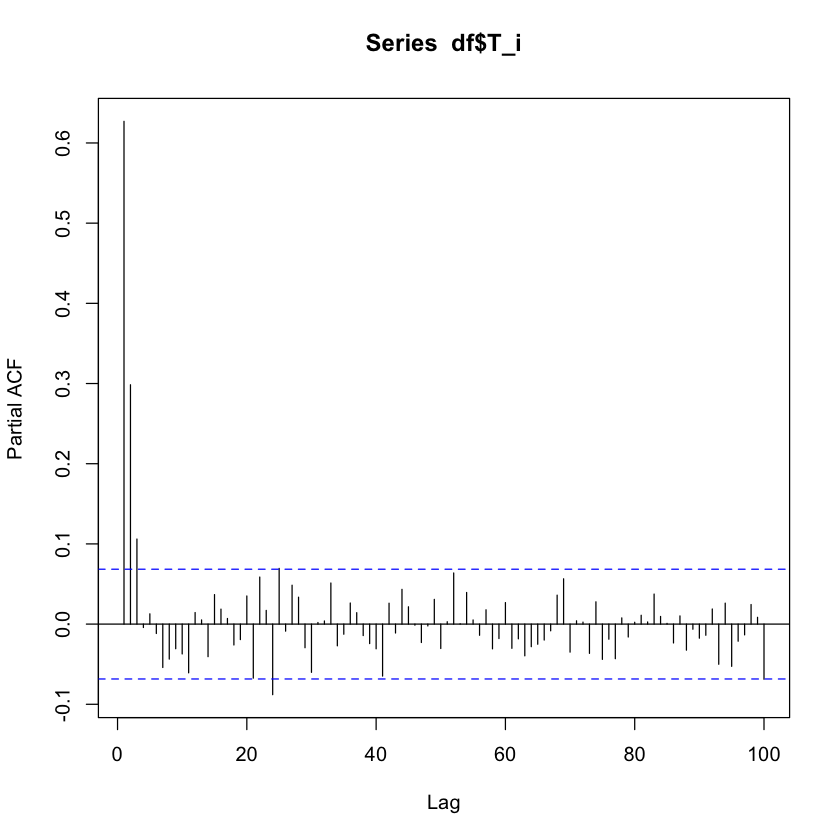

In [352]:
pacf(df$T_i, lag.max = 100, plot=TRUE)